# 2      WiFi Signal for Indoor Localization
We use a WiFi signal dataset for indoor localization. The dataset contains
RSSI (Received Signal Strength Indicator) values from multiple access points
collected in an indoor environment. The training set is provided and you may
split for validation purposes. Your goal is to develop models to predict the
robot’s X, Y coordinates based on the RSSI data. The goal of this coursework
is to develop models for indoor localization using the provided data and analyze
their performance.

In [1]:
# import libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# set random seed for reproducbility
torch.manual_seed(21)
np.random.seed(21)



In [2]:
wifi_df = pd.read_csv('Wifi_train_dataset.csv')
# view the data

print(wifi_df.head())


# look at values and their sizes 
rssi = wifi_df['rssi']
print(f"length of rssi[1]: {len(rssi[1])}")
rssi_split = rssi[1].split(',')
print(f"length of rssi_split[1]: {len(rssi_split)}")
#without splitting rssi/mac, counting up each indivudual number as a character 
print(rssi_split)
    
mac = wifi_df['mac_addrs_idx'][1].split(',')
print(f"length of mac[1]: {len(wifi_df['mac_addrs_idx'][1])}")
rssi_split = rssi[2].split(',')
print(f"length of mac_split[1]: {len(mac)}")
print(mac)



           x          y                                               rssi  \
0  39.300458 -33.832626  -76,-84,-76,-78,-76,-79,-79,-76,-83,-46,-46,-4...   
1  45.667780 -17.235028  -81,-82,-82,-82,-65,-65,-65,-65,-71,-71,-71,-7...   
2  79.944219 -54.821975  -88,-88,-88,-88,-78,-78,-78,-78,-67,-66,-66,-6...   
3  57.353449 -30.499641  -88,-91,-91,-61,-61,-61,-62,-88,-92,-92,-79,-9...   
4  54.454364 -16.056419  -84,-88,-84,-88,-84,-88,-84,-88,-83,-82,-82,-8...   

                                       mac_addrs_idx  
0  68,251,65,46,66,47,48,78,183,95,96,97,143,212,...  
1  126,127,128,129,59,56,57,60,86,85,58,87,120,12...  
2  1,2,3,4,290,289,288,291,5,6,7,8,23,21,152,154,...  
3  113,114,115,1,2,3,4,184,185,186,78,76,119,81,5...  
4  45,68,46,65,47,66,48,78,95,98,96,97,59,56,57,6...  
length of rssi[1]: 547
length of rssi_split[1]: 137
['-81', '-82', '-82', '-82', '-65', '-65', '-65', '-65', '-71', '-71', '-71', '-71', '-81', '-81', '-80', '-81', '-74', '-77', '-77', '-77', '-76', '

## 2.1 Multi-Linear Regression Model for Indoor Localization
We start from the very basic model and your tasks include:

i. Develop a multi-linear regression model to predict the X and Y coordinates
based on the RSSI values (unit: dB) transmitted by the access points (i.e.,
beacons). **[1 mark]**

ii. Report your model’s performance on the validation set using the Mean
Squared Error. **[1 mark]**

Note that there are NaN values in the training set. You are expected to
address it by yourself.

In [ ]:
# each MAC value represents a beacon. Not all inputs will have every beacon. Must check all inputs to find unique beacons

    #convert the string of numbers into individual numbers
def parse_row_to_list(row_str):
    
    if pd.isna(row_str) or row_str == '':
        return []
    return [int(float(x)) for x in str(row_str).split(',')]


def build_feature_matrix(df, dataset_name,num_routers, mac_to_index , sorted_macs):
    print(f"Building {dataset_name} Matrix ")
    
    # create a feature matrix 
    # (Number of Rows, Number of Unique Routers)
    matrix_data = np.full((len(df), num_routers), -110.0)

    # add every signal to corresponding rows
    for i, row in df.iterrows():
        # turn strings into list of numbers
        macs = parse_row_to_list(row['mac_addrs_idx'])
        rssis = parse_row_to_list(row['rssi'])

        # check that every mac adress in each row has a corresponding rssis value
        if len(macs) != len(rssis):
            continue 

        
        for mac, rssi in zip(macs, rssis):
            if mac in mac_to_index:
                col_idx = mac_to_index[mac]
                matrix_data[i, col_idx] = rssi

    
    column_names = [f"Router_{m}" for m in sorted_macs]
    return pd.DataFrame(matrix_data, columns=column_names)

def process_wifi_data(train_df, test_df):

    print("calling preprocessing function")

    # check for every unique router in both the training and test dataset
    all_macs = set()

    for idx_str in train_df['mac_addrs_idx']:
        all_macs.update(parse_row_to_list(idx_str))


    for idx_str in test_df['mac_addrs_idx']:
        all_macs.update(parse_row_to_list(idx_str))

    # sort MACs to ensure columns are always in the same order 
    sorted_macs = sorted(list(all_macs))
    mac_to_index = {mac: i for i, mac in enumerate(sorted_macs)}

    num_routers = len(sorted_macs)
    
    print(f"Found {num_routers} unique routers across all datasets.")

    X_train = build_feature_matrix(train_df, "Training",num_routers , mac_to_index , sorted_macs)
    X_test = build_feature_matrix(test_df, "Test",num_routers , mac_to_index , sorted_macs)


    # training set has x and y. test does not
    y_train = train_df[['x', 'y']]


    print(f"Final Training Shape: {X_train.shape}")
    print(f"Final Test Shape:     {X_test.shape}")
    
    return X_train, y_train, X_test


wifi_test_df = pd.read_csv('Wifi_test_dataset.csv')
print(f"Original training shape: {wifi_df.shape}")
print(f"Original test shape: {wifi_test_df.shape}")
X_train, y_train, X_test = process_wifi_data(wifi_df, wifi_test_df)
X_train.head()

# through some trial and error. -110 performed better than -95,-100,-150


Original training shape: (2880, 4)
Original test shape: (720, 2)
calling preprocessing function
Found 562 unique routers across all datasets.
Building Training Matrix 
Building Test Matrix 
Final Training Shape: (2880, 562)
Final Test Shape:     (720, 562)


,Router_1,Router_2,Router_3,Router_4,Router_5,Router_6,Router_7,Router_8,Router_9,Router_10,...,Router_553,Router_554,Router_555,Router_556,Router_557,Router_558,Router_559,Router_560,Router_561,Router_562
0,-73.0,-73.0,-72.0,-73.0,-78.0,-79.0,-79.0,-110.0,-110.0,-110.0,...,-110.0,-110.0,-110.0,-110.0,-110.0,-110.0,-110.0,-110.0,-110.0,-110.0
1,-72.0,-77.0,-77.0,-77.0,-68.0,-68.0,-68.0,-68.0,-68.0,-110.0,...,-110.0,-110.0,-110.0,-110.0,-110.0,-110.0,-110.0,-110.0,-110.0,-110.0
2,-88.0,-88.0,-88.0,-88.0,-67.0,-66.0,-66.0,-66.0,-110.0,-110.0,...,-110.0,-110.0,-110.0,-110.0,-110.0,-110.0,-110.0,-110.0,-110.0,-110.0
3,-61.0,-61.0,-61.0,-62.0,-63.0,-63.0,-63.0,-63.0,-110.0,-110.0,...,-110.0,-110.0,-110.0,-110.0,-110.0,-110.0,-110.0,-110.0,-110.0,-110.0
4,-110.0,-110.0,-110.0,-110.0,-55.0,-55.0,-55.0,-55.0,-66.0,-66.0,...,-110.0,-110.0,-110.0,-110.0,-110.0,-110.0,-110.0,-110.0,-110.0,-110.0


In [4]:
# split the training data into a training and validation set (allows to tune our model)
# the actual testing (X_test) only has rssi and mac values
# the training (X_train , y_train) has x,y , rssi and mac values

# x contains the rssi and mac values 
# y contains the coordiantes of the robot (x,y)
x_tr , x_val , y_tr , y_val = train_test_split(X_train, y_train , test_size=0.2 ,random_state=42)
print("size of x_tr ", x_tr.shape) #len represents the number of inputs. all should be 
print("size of x_val ", (x_val.shape))
print("size of y_tr ", (y_tr).shape)
print("size of y_val ", (y_val).shape)
LR = LinearRegression()
print("========== Training ===========")
LR.fit(x_tr,y_tr)

#evaluations
val_predictions = LR.predict(x_val)
val_mse = mean_squared_error(y_val , val_predictions)
print(f"Validation MSE: {val_mse:.2f}")



size of x_tr  (2304, 562)
size of x_val  (576, 562)
size of y_tr  (2304, 2)
size of y_val  (576, 2)
========== Training ===========
Validation MSE: 23.09


MSE of around 23 $meters^2$. RMSE of around 4.9 which means theres an average error of around 5 meters. This value proves to be a baseline. A linear model most likely wouldnt work for this system as the data is most probably non linear data. dB works logarithmically so it matches up

# 2.2 Neural Network Model for Indoor Localization
We then move to using more complicated models to process the data. Your
tasks include:

i. Develop a neural network (NN) model to predict the X and Y coordinates
from the RSSI data. You are free to decide the architecture of the NN based on
your own exploration and analysis. **[2 marks]**

ii. Report the validation results of your NN model and compare it with the
linear regression model. **[2 mark]**


In [ ]:
# create the neural network class 


class NN_model(nn.Module):
    # Initialize the model
    def __init__(self,input_dim):
        super(NN_model, self).__init__() 
        # number of routers = 562 (input neurons)
        # need x and y coordiantes so 2 output neurons 
        self.model = nn.Sequential(
            #1st hidden layer 
            nn.Linear(input_dim,128),
            nn.ReLU(),
            #2nd hidden layer 
            nn.Linear(128,64),
            nn.ReLU(),
            #output layer
            nn.Linear(64,2)
        )
    # Define the forward pass (how data flows through the model)
    def forward(self, x):
        return self.model(x)  # Pass the input through the linear layer
    
# another nn model with a different architecture 
class NN3_model(nn.Module):
    def __init__(self, input_dim):
        super(NN3_model,self).__init__()
        self.model = nn.Sequential(
                    # Layer 1
                    nn.Linear(input_dim, 512),
                    nn.ReLU(),
                    nn.Dropout(0.1),  
                    
                    # Layer 2
                    nn.Linear(512, 256),
                    nn.ReLU(),
                    nn.Dropout(0.1),
                    
                    # Layer 3
                    nn.Linear(256, 128),
                    nn.ReLU(),
                
                    
                    # Output
                    nn.Linear(128, 2)    
                )

    # Define the forward pass (how data flows through the model)
    def forward(self, x):
        return self.model(x)  # Pass the input through the linear layer





In [ ]:
# instantiate model
size = X_train.shape[1]
model = NN3_model(size)

# find loss using MSE
criterion = nn.MSELoss()


#optimizer = optim.SGD(model.parameters(), lr=0.01)

optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# convert data to tensors
scaler_x = StandardScaler()
# fit on the new training split (x_tr)
x_tr_scaled = scaler_x.fit_transform(x_tr)
#apply transformation to validation set (x_val)
x_val_scaled = scaler_x.transform(x_val) 

scaler_y = StandardScaler()
y_tr_scaled = scaler_y.fit_transform(y_tr)
y_val_scaled = scaler_y.transform(y_val)
# use fit_transform() on training to work out values 
# use transform() on validation set to reuse same scaling values (means, standard deviations)

X_train_tensor = torch.tensor(x_tr_scaled, dtype=torch.float32)
Y_train_tensor = torch.tensor(y_tr_scaled, dtype=torch.float32)
X_val_tensor = torch.tensor(x_val_scaled, dtype=torch.float32)


# train the model
loss_history = []
num_epochs = 1000   
for epoch in range(num_epochs):
    model.train()
    
    # Forward pass
    outputs = model(X_train_tensor)
    loss = criterion(outputs, Y_train_tensor)
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    loss_history.append(loss.item())
    
    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [100/1000], Loss: 0.0169
Epoch [200/1000], Loss: 0.0076
Epoch [300/1000], Loss: 0.0059
Epoch [400/1000], Loss: 0.0047
Epoch [500/1000], Loss: 0.0039
Epoch [600/1000], Loss: 0.0043
Epoch [700/1000], Loss: 0.0033
Epoch [800/1000], Loss: 0.0033
Epoch [900/1000], Loss: 0.0033
Epoch [1000/1000], Loss: 0.0026


Neural Network Validation MSE: 8.39


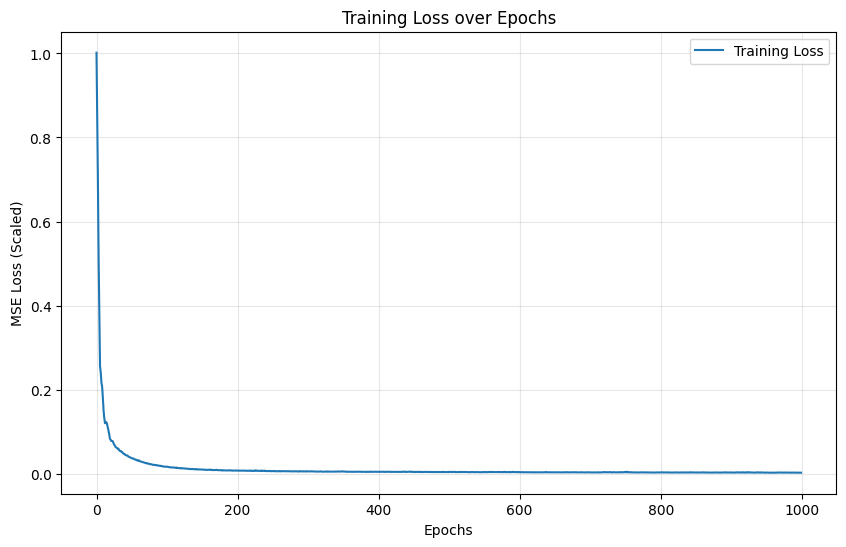

In [8]:
# evaluate model 
model.eval()
with torch.no_grad():
    # Predict on Validation
    val_preds_scaled = model(X_val_tensor)
    
    # use inverse transform to go back to original values 
    val_preds_real = scaler_y.inverse_transform(val_preds_scaled.numpy())
    
    # Calculate MSE on real coordinates
    nn_mse = mean_squared_error(y_val, val_preds_real)
    print(f"Neural Network Validation MSE: {nn_mse:.2f}")

plt.figure(figsize=(10, 6))
plt.plot(loss_history, label='Training Loss')
plt.title('Training Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss (Scaled)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

### attempt 1 
regular linear model with SGD 562 -> 2  : MSE = 22.05 (1000 epochs)
### attempt 2 
2 hidden layers with SGD  562 -> 128 -> 64 -> 2  : MSE = 15.91 (1200 epochs)
### attempt 3 
2 hidden layers with Adam  562 -> 128 -> 64 -> 2  : MSE = 12.43 (1200 epochs)
### attempt 4 
3 hidden layers with Adam 562 -> 512 -> 128 -> 64 -> 2 : MSE = 8.33  (NN3)  (1000 epochs)

In [ ]:
def calculate_MPE(y_true , y_pred):

    # create numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Extract X and Y components
    # first column is X values, 2nd column is Y values 
    x_true = y_true[:, 0]
    y_true = y_true[:, 1]
    
    x_pred = y_pred[:, 0]
    y_pred = y_pred[:, 1]
    
    # add epsilon to prevent any zero divisions
    epsilon = 1e-10
    
    # calculate errors
    x_error = np.abs(x_pred - x_true) / (np.abs(x_true) + epsilon)
    y_error = np.abs(y_pred - y_true) / (np.abs(y_true) + epsilon)
    
    # average the errors
    row_mpe = 0.5 * (x_error + y_error)
    
    # Final Mean over all rows
    mpe_final = np.mean(row_mpe)
    
    return mpe_final

mpe_score = calculate_MPE(y_val, val_preds_real)
print(f"Mean Percentage Error (MPE): {mpe_score:.4f}")
print(f"Score Metric: {mpe_score * 100:.2f}%")

Mean Percentage Error (MPE): 0.0791
Score Metric: 7.91%


### 2.3 Dimensionality Reduction for Feature Visualization
Let’s dive deep into what the Neural Network learns. Your tasks include:

i. Extract the feature representations from a layer in the NN that you think
can be mostly useful. Without using the labelled coordinates, apply a clustering
method on the extracted features and provide your findings.**[2 marks]**

In [ ]:
feature_rep = nn.Sequential(*list(model.model.children())[:-1])
#set to evaluation mode 
feature_rep.eval()

with torch.no_grad():
    # Pass the training data through the partial model (use the entire model)
    hidden_features_tensor = feature_rep(X_train_tensor)
    
    # Convert to numpy so its usable with sklearn 
    hidden_features = hidden_features_tensor.detach().numpy()

print(f"Original Input Shape: {X_train_tensor.detach().numpy().shape}") #  (rows, 562)
print(f"Hidden Features Shape: {hidden_features.shape}") #  (rows, 128)



Original Input Shape: (2304, 562)
Hidden Features Shape: (2304, 128)


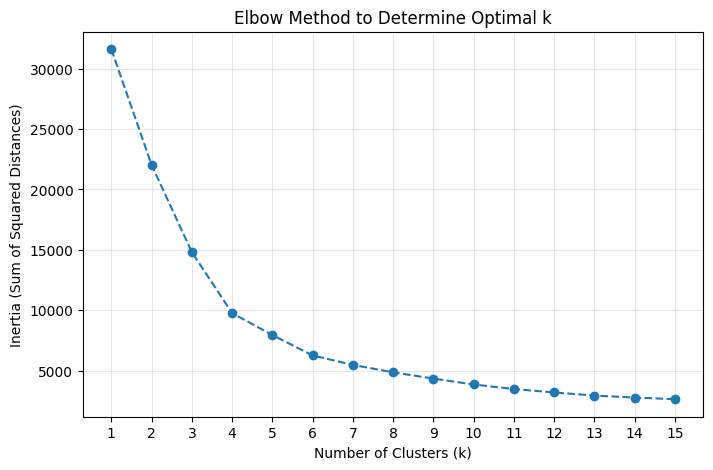

In [11]:
# test different cluster values 
k_values = range(1, 16)
inertias = []

for k in k_values:
    # train K-Means on the hidden features
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(hidden_features)

    inertias.append(km.inertia_)

# find the elbow join 
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertias, marker='o', linestyle='--')
plt.title('Elbow Method to Determine Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Sum of Squared Distances)')
plt.xticks(k_values)
plt.grid(True, alpha=0.3)
plt.show()



In [ ]:
num_clusters = 6
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
# fit kmeans onto the hidden features (128 neurons)
cluster_labels = kmeans.fit_predict(hidden_features)
# check each cluster and how many points
unique, counts = np.unique(cluster_labels, return_counts=True)
print("Cluster Distribution:")
for cluster_id, count in zip(unique, counts):
    print(f"Cluster {cluster_id}: {count} samples")
    
# ideal number of clusters is 6

Cluster Distribution:
Cluster 0: 384 samples
Cluster 1: 541 samples
Cluster 2: 201 samples
Cluster 3: 344 samples
Cluster 4: 353 samples
Cluster 5: 481 samples


ii. Apply a dimensionality reduction method (e.g., t-SNE, PCA) to visualize
the feature space in 2D. Provide insights into the learned feature representations
and their relation to the localization task.**[2 marks]**

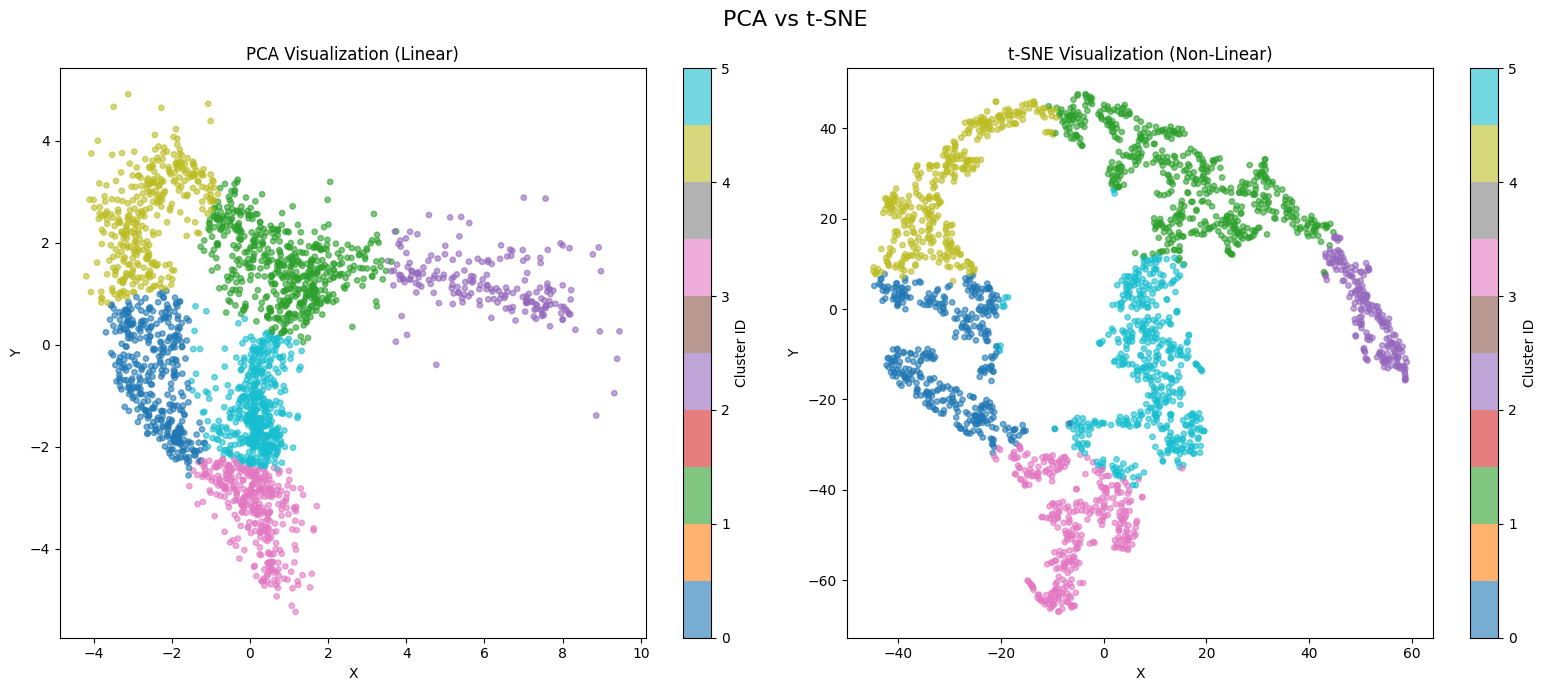

In [20]:

pca = PCA(n_components=2)
pca_results = pca.fit_transform(hidden_features)

tsne = TSNE(n_components=2, perplexity=30, random_state=42 )
tsne_results = tsne.fit_transform(hidden_features) 

# --- 2. Plotting Comparison ---
plt.figure(figsize=(16, 7))

# PCA plot
plt.subplot(1, 2, 1)
scatter_pca = plt.scatter(
    pca_results[:, 0], 
    pca_results[:, 1], 
    c=cluster_labels, 
    cmap='tab10', 
    alpha=0.6, 
    s=15
)
plt.title('PCA Visualization (Linear)')
plt.xlabel('X')
plt.ylabel('Y')
plt.colorbar(scatter_pca, label='Cluster ID')

# t-SNE plot
plt.subplot(1, 2, 2)
scatter_tsne = plt.scatter(
    tsne_results[:, 0], 
    tsne_results[:, 1], 
    c=cluster_labels, 
    cmap='tab10', 
    alpha=0.6, 
    s=15
)
plt.title('t-SNE Visualization (Non-Linear)')
plt.xlabel('X')
plt.ylabel('Y')
plt.colorbar(scatter_tsne, label='Cluster ID')

plt.suptitle("PCA vs t-SNE", fontsize=16)
plt.tight_layout()
plt.show()

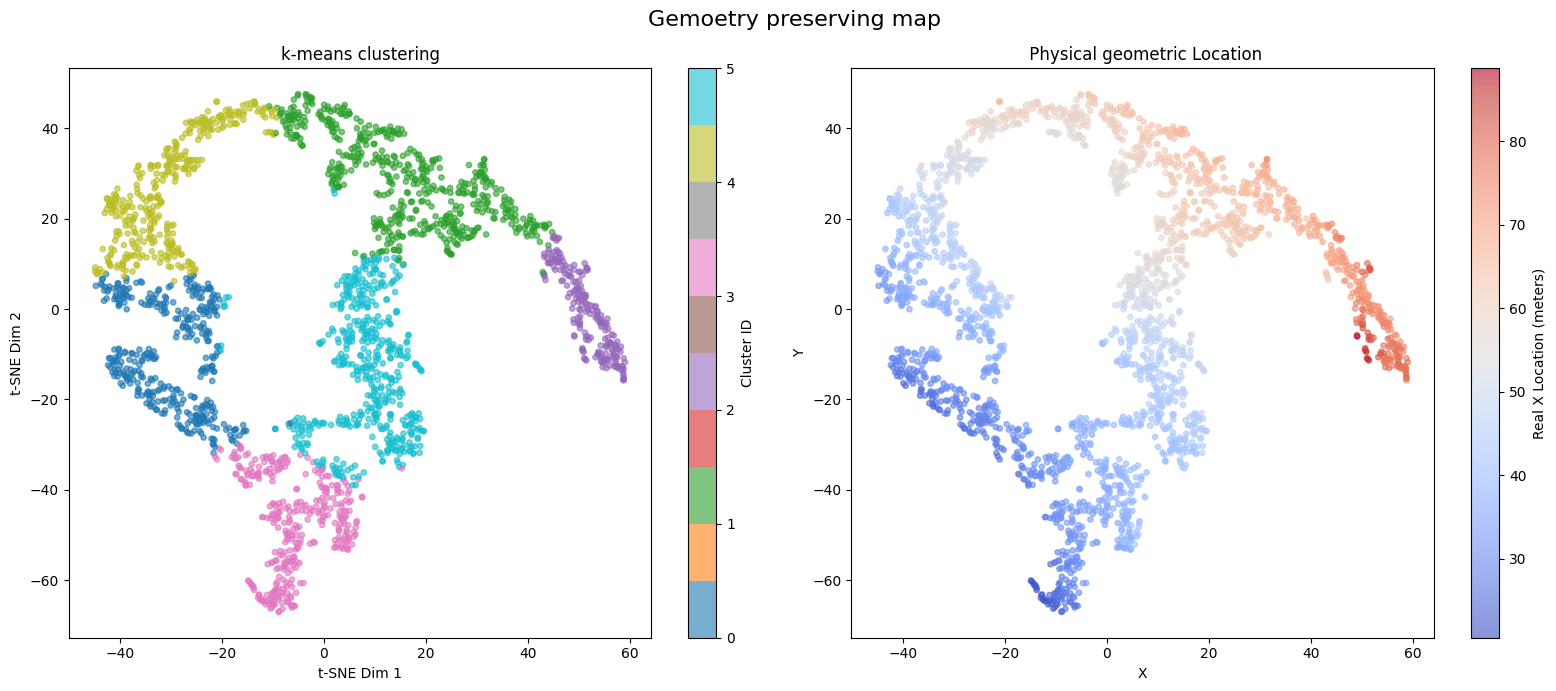

In [22]:

y_train_real = scaler_y.inverse_transform(Y_train_tensor.numpy())
real_x_values = y_train_real[:, 0] # Column 0 is the X-coordinate


plt.figure(figsize=(16, 7))

#plot tsne
plt.subplot(1, 2, 1)
scatter_cluster = plt.scatter(
    tsne_results[:, 0], 
    tsne_results[:, 1], 
    c=cluster_labels, 
    cmap='tab10', 
    alpha=0.6, 
    s=15
)
plt.title('k-means clustering')
plt.xlabel('t-SNE Dim 1')
plt.ylabel('t-SNE Dim 2')
plt.colorbar(scatter_cluster, label='Cluster ID')

#plot gemotric positions 
plt.subplot(1, 2, 2)
scatter_physical = plt.scatter(
    tsne_results[:, 0], 
    tsne_results[:, 1], 
    c=real_x_values, 
    cmap='coolwarm', # Blue to Red gradient
    alpha=0.6, 
    s=15
)
plt.title(' Physical geometric Location')
plt.xlabel('X')
plt.ylabel('Y')
plt.colorbar(scatter_physical, label='Real X Location (meters)')

plt.suptitle("Gemoetry preserving map", fontsize=16)
plt.tight_layout()
plt.show()

PCA is cramming the data into a smaller space. cant capture the non linear data. t-SNE is able to capture the non linearity 

In [15]:
X_test # test data already broken into multiple routers 


,Router_1,Router_2,Router_3,Router_4,Router_5,Router_6,Router_7,Router_8,Router_9,Router_10,...,Router_553,Router_554,Router_555,Router_556,Router_557,Router_558,Router_559,Router_560,Router_561,Router_562
0,-73.0,-73.0,-73.0,-73.0,-75.0,-75.0,-75.0,-110.0,-86.0,-110.0,...,-110.0,-110.0,-110.0,-110.0,-110.0,-110.0,-110.0,-110.0,-110.0,-110.0
1,-64.0,-64.0,-64.0,-64.0,-40.0,-40.0,-40.0,-40.0,-82.0,-82.0,...,-110.0,-110.0,-110.0,-110.0,-110.0,-110.0,-110.0,-110.0,-110.0,-110.0
2,-79.0,-81.0,-79.0,-79.0,-79.0,-79.0,-79.0,-80.0,-70.0,-70.0,...,-110.0,-110.0,-110.0,-110.0,-110.0,-110.0,-110.0,-110.0,-110.0,-110.0
3,-84.0,-85.0,-85.0,-84.0,-77.0,-77.0,-77.0,-77.0,-71.0,-71.0,...,-110.0,-110.0,-110.0,-110.0,-110.0,-110.0,-110.0,-110.0,-110.0,-110.0
4,-84.0,-83.0,-84.0,-84.0,-86.0,-85.0,-86.0,-86.0,-80.0,-72.0,...,-110.0,-110.0,-110.0,-110.0,-110.0,-110.0,-110.0,-110.0,-110.0,-110.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,-64.0,-64.0,-64.0,-64.0,-50.0,-50.0,-49.0,-49.0,-110.0,-110.0,...,-110.0,-110.0,-110.0,-110.0,-110.0,-110.0,-110.0,-110.0,-110.0,-110.0
716,-73.0,-73.0,-73.0,-73.0,-72.0,-73.0,-73.0,-72.0,-84.0,-84.0,...,-110.0,-110.0,-110.0,-110.0,-110.0,-110.0,-110.0,-110.0,-110.0,-110.0
717,-60.0,-60.0,-60.0,-60.0,-46.0,-46.0,-46.0,-47.0,-78.0,-79.0,...,-110.0,-110.0,-110.0,-110.0,-110.0,-110.0,-110.0,-110.0,-110.0,-110.0
718,-57.0,-57.0,-57.0,-57.0,-49.0,-49.0,-49.0,-49.0,-83.0,-110.0,...,-110.0,-110.0,-110.0,-110.0,-110.0,-110.0,-110.0,-110.0,-110.0,-110.0


### 2.4 Prediction and Analysis on Test Data
Finally, let’s evaluate your models with our held-out test set. Your tasks include
using the test data provided separately, predict the X and Y coordinates with
the model you decide to use. You can only choose one model and report one
test prediction file. **[3 marks]**

In [16]:
#NEED TO:
# use the neural network to predict test values 
# store in a csv 
# question done

# scale the test data using the same scale used for training data
X_test_scaled = scaler_x.transform(X_test)
# convert into tensor 
X_test_scaled_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)

#set model to eval mode so that it predicts 
model.eval()
with torch.no_grad():
    test_pred_scaled = model(X_test_scaled_tensor)
    test_pred_scaled_np = test_pred_scaled.numpy() #covert into numpy for easier use 

#convert scaled units back to original 
test_pred_real = scaler_y.inverse_transform(test_pred_scaled_np)
test_pred_real_df = pd.DataFrame(test_pred_real, columns=['X', 'Y'])
#print the head to view data 
print(test_pred_real_df.head(10))



           X          Y
0  54.560692 -30.919601
1  70.691116 -42.651657
2  37.346561 -19.467146
3  45.349277 -15.257744
4  31.933271 -21.128298
5  34.500793 -30.634739
6  48.735039 -33.195778
7  75.763840 -41.759144
8  36.749443 -32.611706
9  30.620583 -29.366474


In [17]:
# store in a csv 
student_id = "zcabais"
filename = f"{student_id}.txt"
print(filename)
test_pred_real_df.to_csv(filename, index=False) #index = false means no row numbers. 

zcabais.txt
